## Introduction

**Neurotoxicity** is one of the main causes of drug withdrawal, and the biological experimental methods of detecting `neurotoxic toxicity` are `time-consuming` and `laborious`. In addition, the existing computational prediction models of neurotoxicity still have some shortcomings. In response to these shortcomings, this project aims to use a large number of data related to **human toxicity** and `RDKit molecular descriptors` to construct **machine learning** classification model of chemical `neurotoxicity`.

## Importing all the tools we need.

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import seaborn as sns
import lazypredict
import rdkit
import mols2grid
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from chemplot import Plotter
%matplotlib inline 

# Models from Scikit-Learn
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

# Model for Evaluations
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import RocCurveDisplay

### Load Data
This [dataset](https://acs.figshare.com/articles/dataset/_i_In_Silico_i_Prediction_of_Human_Organ_Toxicity_via_Artificial_Intelligence_Methods/23497439) contains more than **2,000 chemicals** coupled with their `SMILES` and `CAS numbers` as well as eight significant human organ level toxicity `end points`.

In [2]:
df = pd.read_csv("tx2c00411_si_002.csv")
df.shape

(2389, 11)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2389 entries, 0 to 2388
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CASRN                   2389 non-null   object 
 1   carcinogenicity         2383 non-null   float64
 2   cardiotoxicity          2383 non-null   float64
 3   developmental toxicity  2383 non-null   float64
 4   hepatotoxicity          2383 non-null   float64
 5   nephrotoxicity          2383 non-null   float64
 6   neurotoxicity           2383 non-null   float64
 7   reproductive toxicity   2383 non-null   float64
 8   skin sensitization      345 non-null    float64
 9   Name                    2389 non-null   object 
 10  SMILES                  2360 non-null   object 
dtypes: float64(8), object(3)
memory usage: 205.4+ KB


## Exploratory Data Analysis (EDA)

In [4]:
df.head()

,CASRN,carcinogenicity,cardiotoxicity,developmental toxicity,hepatotoxicity,nephrotoxicity,neurotoxicity,reproductive toxicity,skin sensitization,Name,SMILES
0,100-06-1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,4'-Methoxyacetophenone,COC1=CC=C(C=C1)C(C)=O
1,100-11-8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4-Nitrobenzyl bromide,[O-][N+](=O)C1=CC=C(CBr)C=C1
2,100-14-1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4-Nitrobenzyl chloride,[O-][N+](=O)C1=CC=C(CCl)C=C1
3,100-37-8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,2-(Diethylamino)ethanol,CCN(CC)CCO
4,100-39-0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,BENZYL BROMIDE,BrCC1=CC=CC=C1


Since we are just interested in predicting **neurotoxicity**, we will remove all the other columns, leaving only `SMILES` and `neurotoxicity`.

In [5]:
df = df.drop(['CASRN', 'carcinogenicity', 'cardiotoxicity', 'developmental toxicity',
       'hepatotoxicity', 'nephrotoxicity', 'reproductive toxicity', 'skin sensitization', 'Name'],axis=1)
df.head(10)

,neurotoxicity,SMILES
0,0.00,COC1=CC=C(C=C1)C(C)=O
1,0.00,[O-][N+](=O)C1=CC=C(CBr)C=C1
2,0.00,[O-][N+](=O)C1=CC=C(CCl)C=C1
3,0.00,CCN(CC)CCO
4,0.00,BrCC1=CC=CC=C1
5,0.00,CCC1=CC=CC=C1
6,1.00,C=CC1=CC=CC=C1
7,0.00,C=CC1=CC=NC=C1
8,1.00,OCC1=CC=CC=C1
9,0.00,O=CC1=CC=CC=C1


In [6]:
# Check for any missing values
df.isna().sum()

neurotoxicity     6
SMILES           29
dtype: int64

In [7]:
# Remove all missing values
df.dropna(inplace=True)
df.isna().sum()

neurotoxicity    0
SMILES           0
dtype: int64

**RDKit** and **mols2grid** allow us to visualise our chemicals and even export them as `SMI` or `CSV` files.

In [8]:
# Visualising Chemicals
smiles_list = df['SMILES'].to_list()
chems = [rdkit.Chem.MolFromSmiles(x) for x in smiles_list]
mols2grid.display(chems)

MolGridWidget()

### Calculation of molecular descriptors
For the compiled toxicity data, we will use the **RDKit python package** to calculate the `molecular descriptors` of the compounds.

In [9]:
def descriptors(smiles, verbose=False):

    des_list = [x[0] for x in Descriptors._descList]
    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        calculator = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
        row = np.array(calculator.CalcDescriptors(mol))

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames = des_list
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

df = pd.concat([df, descriptors(df['SMILES'])], axis=1)

[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerator
[02:18:48] DEPRECATION WARNING: please use MorganGenerat

In [10]:
df.head()

,neurotoxicity,SMILES,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.00,COC1=CC=C(C=C1)C(C)=O,10.80,10.80,0.08,0.08,0.60,9.27,150.18,140.10,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,[O-][N+](=O)C1=CC=C(CBr)C=C1,10.19,10.19,0.13,-0.40,0.43,9.55,216.03,209.99,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,[O-][N+](=O)C1=CC=C(CCl)C=C1,10.17,10.17,0.10,-0.43,0.39,9.55,171.58,165.53,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,CCN(CC)CCO,8.46,8.46,0.28,0.28,0.57,10.50,117.19,102.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,BrCC1=CC=CC=C1,3.36,3.36,0.95,0.95,0.57,9.12,171.04,163.98,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [11]:
df.T.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2350,2351,2352,2353,2354,2355,2356,2357,2358,2359
neurotoxicity,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,...,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
SMILES,COC1=CC=C(C=C1)C(C)=O,[O-][N+](=O)C1=CC=C(CBr)C=C1,[O-][N+](=O)C1=CC=C(CCl)C=C1,CCN(CC)CCO,BrCC1=CC=CC=C1,CCC1=CC=CC=C1,C=CC1=CC=CC=C1,C=CC1=CC=NC=C1,OCC1=CC=CC=C1,O=CC1=CC=CC=C1,...,C(CS)N.Cl,C(CS)N,C1CN2CC3=CCOC4CC(=O)N5C6C4C3CC2C61C7=CC=CC=C75,C1CN2CC3=CCOC4CC(=O)N5C6C4C3CC2C61C7=CC=CC=C75...,C1CCN(CC1)CCOC2=CC=C(C=C2)C(=O)C3=C(SC4=C3C=CC...,C1CCN(CC1)CCOC2=CC=C(C=C2)C(=O)C3=C(SC4=C3C=CC...,C1CN(CCN1CCOCCO)C(C2=CC=CC=C2)C3=CC=C(C=C3)Cl.Cl,C1CN(CCN1CCOCCO)C(C2=CC=CC=C2)C3=CC=C(C=C3)Cl,NN.OS(=O)(=O)O,OS(=O)(=O)O
MaxAbsEStateIndex,10.80,10.19,10.17,8.46,3.36,2.16,3.63,3.85,8.54,10.01,...,4.95,4.95,13.18,13.18,13.65,13.65,8.78,8.78,8.74,8.74
MaxEStateIndex,10.80,10.19,10.17,8.46,3.36,2.16,3.63,3.85,8.54,10.01,...,4.95,4.95,13.18,13.18,13.65,13.65,8.78,8.78,8.74,8.74
MinAbsEStateIndex,0.08,0.13,0.10,0.28,0.95,1.14,1.17,1.11,0.14,0.73,...,0.00,0.68,0.10,0.10,0.00,0.08,0.00,0.09,4.00,4.67
MinEStateIndex,0.08,-0.40,-0.43,0.28,0.95,1.14,1.17,1.11,0.14,0.73,...,0.00,0.68,0.10,-4.67,-0.08,-0.08,0.00,0.09,-4.67,-4.67
qed,0.60,0.43,0.39,0.57,0.57,0.51,0.51,0.53,0.57,0.50,...,0.47,0.42,0.68,0.30,0.28,0.32,0.68,0.72,0.17,0.39
SPS,9.27,9.55,9.55,10.50,9.12,9.12,8.50,8.50,9.12,8.50,...,6.00,7.50,45.92,42.80,13.94,14.35,16.67,17.31,9.14,11.60
MolWt,150.18,216.03,171.58,117.19,171.04,106.17,104.15,105.14,108.14,106.12,...,113.61,77.15,334.42,766.92,510.06,473.59,411.37,374.91,130.12,98.08
HeavyAtomMolWt,140.10,209.99,165.53,102.07,163.98,96.09,96.09,98.08,100.08,100.08,...,105.55,70.10,312.24,720.55,481.83,446.38,383.15,347.70,124.08,96.06


### Class Balance
A **problem** may arise when the number of instances in each `class` of a `dataset` is not balanced. This has a significant impact on the performance of **machine learning models**. The `models` trained on such data tend to be biased towards the `majority class`.

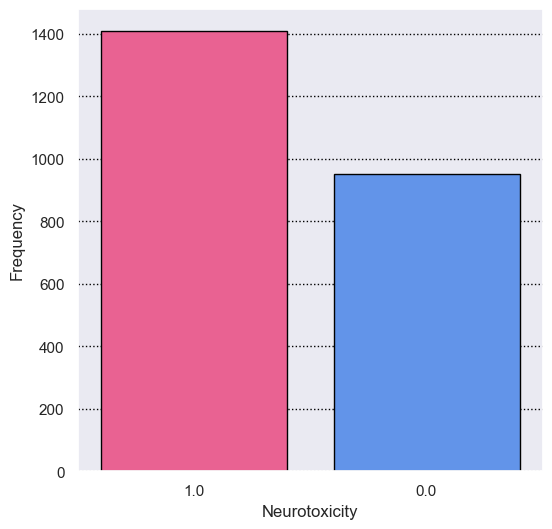

In [12]:
#Choose a style for the plot
sns.set_style("darkgrid", {"grid.color": "black", "grid.linestyle": ":"})
sns.set_context("notebook")

plt.subplots(figsize=(6, 6))
palette = ["#ff4c8b", "#4c8eff"]
sns.countplot(x='neurotoxicity', data=df, order = df['neurotoxicity'].value_counts().index, palette=palette, edgecolor='black')
plt.xlabel('Neurotoxicity')
plt.ylabel('Frequency');

It appears that the **data** in this case is relatively `balanced`, there is a little bit more **samples** from one of the **classes**, but not enough to worry about.

### LogP distribution

**LogP** is the log of the **partition coefficient (P)** of a solute between `octanol` and `water`, it is used in the **pharmaceutical/biotech industries** to understand the behavior of drug molecules in the body. The **partition coefficient (P)** describes the propensity of a `neutral (uncharged) compound` to dissolve in an `immiscible biphasic system` of lipid (**fats**, **oils**, **organic solvents**) and `water`. In simple terms, it measures how much of a solute dissolves in the `water portion` versus an `organic portion`.

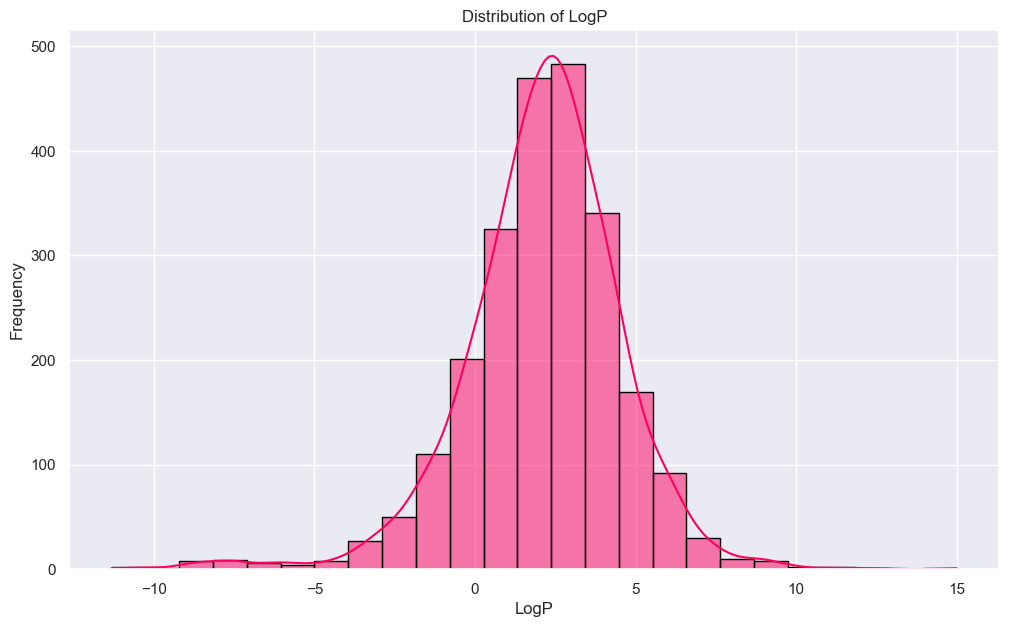

In [13]:
#Choose a style for the plot
sns.set_style('darkgrid')

# Visualize LogP distribution
plt.figure(figsize=(12,7))
sns.histplot(data=df, x='MolLogP', color='#FF005E', edgecolor='black', bins=25, kde=True)
plt.title('Distribution of LogP')
plt.xlabel('LogP')
plt.ylabel('Frequency');

### Distribution of Number of Atoms
In **SMILES**, the `H atoms` are usually ignored, therefore we must add them first before proceeding.

In [14]:
# Getting the number of atoms
df_copy = df.copy()
df_copy['mol'] = df_copy['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 
df_copy['mol'] = df_copy['mol'].apply(lambda x: Chem.AddHs(x))
df_copy['num_of_atoms'] = df_copy['mol'].apply(lambda x: x.GetNumAtoms())

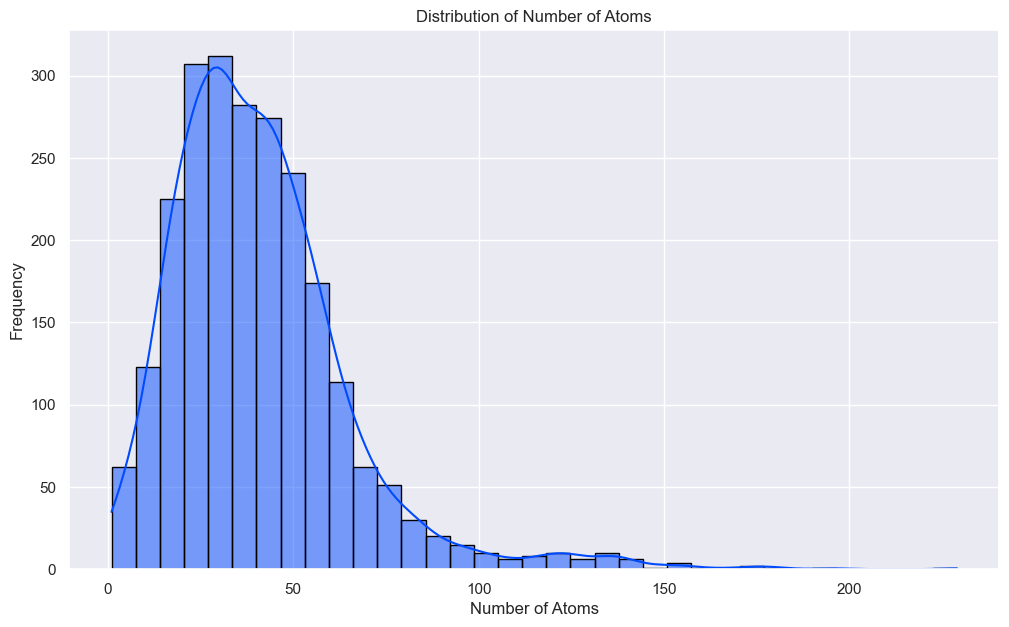

In [15]:
#Choose a style for the plot
sns.set_style('darkgrid')

# Visualize LogP distribution
plt.figure(figsize=(12,7))
sns.histplot(data=df_copy, x='num_of_atoms', color='#004aff', edgecolor='black', bins=35, kde=True)
plt.title('Distribution of Number of Atoms')
plt.xlabel('Number of Atoms')
plt.ylabel('Frequency');

### LogP vs. Number of Atoms

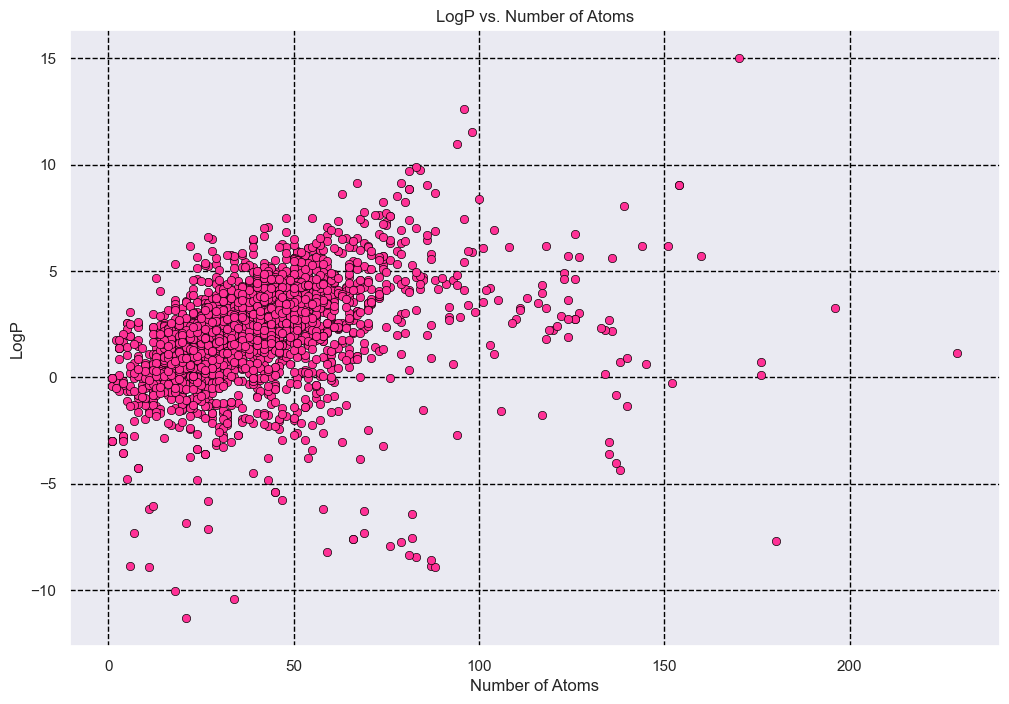

In [16]:
#Choose a style for the plot
custom = {"grid.linestyle": "dashed", "grid.color": "black"}
sns.set_style("darkgrid", rc = custom)

plt.figure(figsize=(12,8))
sns.scatterplot(data=df_copy, x='num_of_atoms', y='MolLogP', color='#ff3196', edgecolor='black')
plt.title('LogP vs. Number of Atoms')
plt.xlabel('Number of Atoms')
plt.ylabel('LogP');

### LogP vs Neurotoxicity

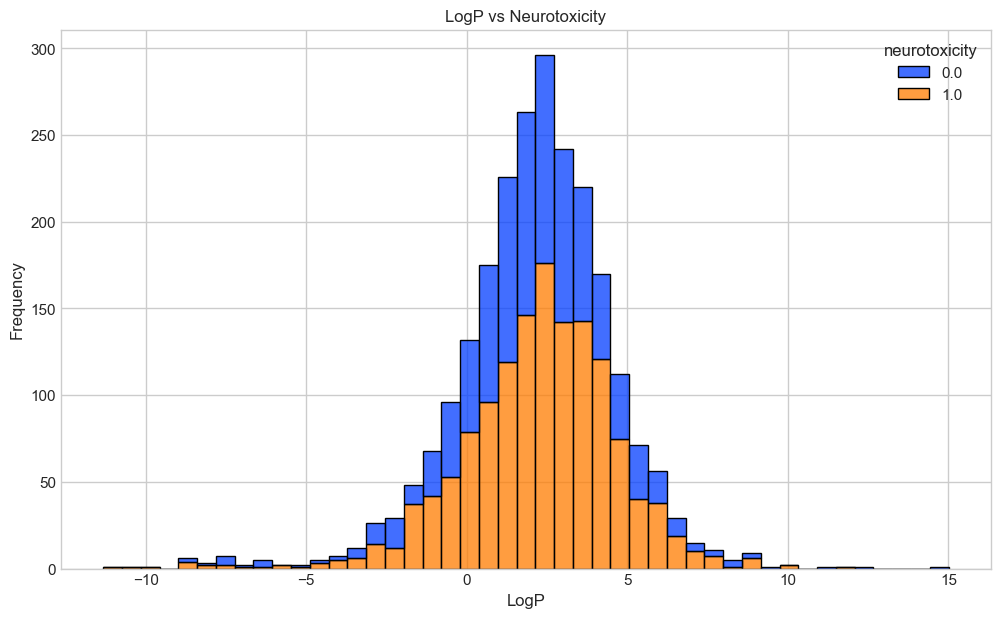

In [17]:
#Choose a style for the plot
plt.style.use("seaborn-v0_8-whitegrid")

# Plot the distribution of LogP vs Neurotoxicity
plt.figure(figsize=(12,7))
sns.histplot(data=df, x='MolLogP', bins=45, hue='neurotoxicity', palette="bright", multiple='stack', edgecolor='black')
plt.xlabel('LogP')
plt.ylabel('Frequency')
plt.title('LogP vs Neurotoxicity');

### Distribution of Hydrogen Bond Donors & Hydrogen Bond Acceptors

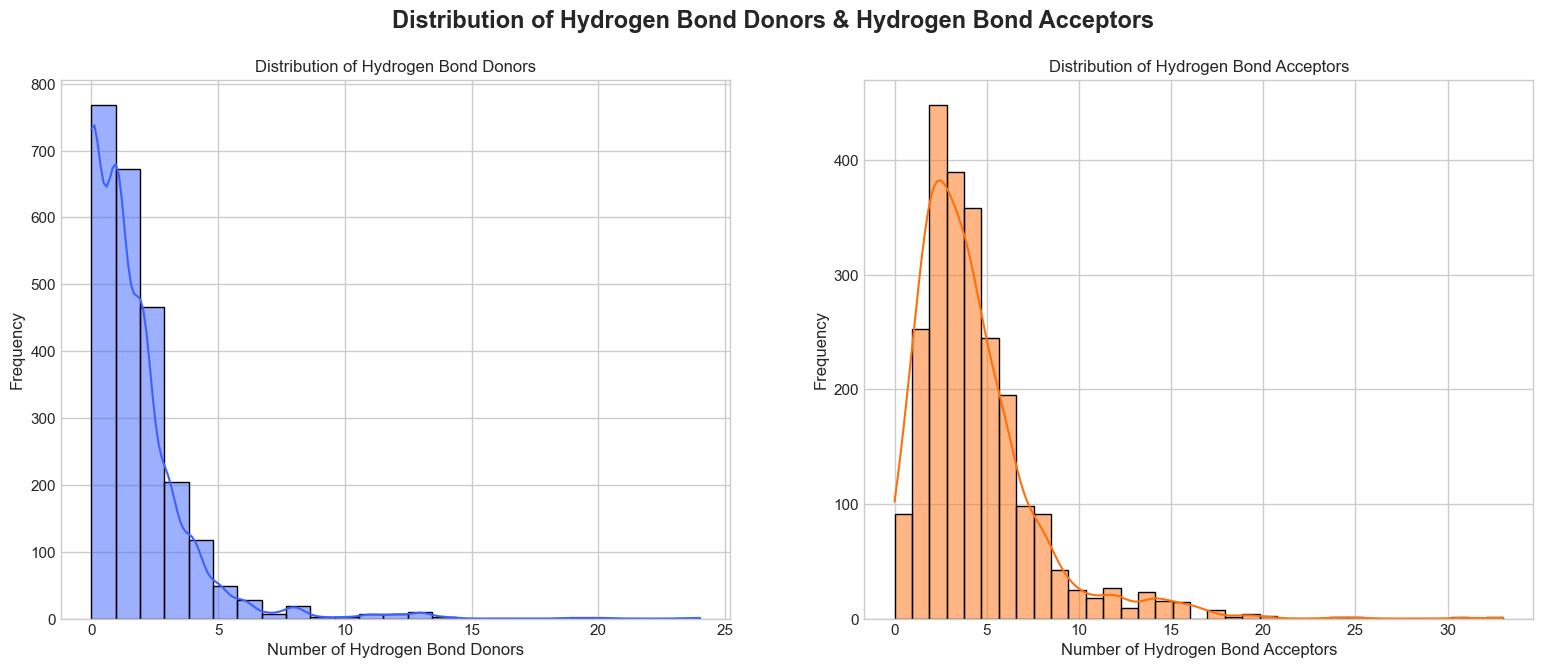

In [18]:
# Create a figure and axes with 1 row and 2 columns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(19, 7))

# Visualising the distribution of Hydrogen Bond Donors
sns.histplot(data=df, x='NumHDonors', color='#3d61ff', edgecolor='black', bins=25, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Hydrogen Bond Donors')
ax[0].set_xlabel('Number of Hydrogen Bond Donors')
ax[0].set_ylabel('Frequency');

# Visualising the distribution of Hydrogen Bond Acceptors
sns.histplot(data=df, x='NumHAcceptors', color='#ff6f0a', edgecolor='black', bins=35, kde=True, ax=ax[1])
ax[1].set_title('Distribution of Hydrogen Bond Acceptors')
ax[1].set_xlabel('Number of Hydrogen Bond Acceptors')
ax[1].set_ylabel('Frequency');

fig.suptitle("Distribution of Hydrogen Bond Donors & Hydrogen Bond Acceptors", fontsize=17, fontweight="bold");

## Feature Selection
**feature selection** helps to identify the most important `features` in a dataset and remove the `noise` or `irrelevant information`. This procedure can help to reduce the `dimensionality` of datasets, as **high-dimensional datasets** can lead to `overfitting` and `poor performance` of **machine learning models**.

In [19]:
# Spliting data into X and y
X = df.drop(['neurotoxicity','SMILES'],axis=1)
y = df['neurotoxicity']

In [20]:
# Setup random seed
np.random.seed(50)

# Split data into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Remove duplicate columns

In [21]:
def get_duplicate_columns(df):
    
    duplicate_columns = {}
    seen_columns = {}

    for column in df.columns:
        current_column = df[column]

        # Convert column data to bytes
        try:
            current_column_hash = current_column.values.tobytes()
        except AttributeError:
            current_column_hash = current_column.to_string().encode()

        if current_column_hash in seen_columns:
            if seen_columns[current_column_hash] in duplicate_columns:
                duplicate_columns[seen_columns[current_column_hash]].append(column)
            else:
                duplicate_columns[seen_columns[current_column_hash]] = [column]
        else:
            seen_columns[current_column_hash] = column

    return duplicate_columns

In [22]:
duplicate_columns = get_duplicate_columns(X_train)
for one_list in duplicate_columns.values():
    X_train.drop(columns=one_list,inplace=True)
    X_test.drop(columns=one_list,inplace=True)

X_train.shape

(1888, 204)

### Variance threshold
**Variance threshold** is a `filter-based` feature selection method used to remove `low-variance features` from a dataset. The basic idea behind this method is that `features` with `low variance` are not useful in predicting the `target variable` and can be safely `removed` from the dataset.

In [23]:
sel = VarianceThreshold(threshold=0.69)
sel.fit(X_train)

VarianceThreshold(threshold=0.69)

In [24]:
columns = X_train.columns[sel.get_support()]

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

X_train.shape

(1888, 116)

### ANOVA F-test
**Analysis of variance (ANOVA)** is used to determine if there are `statistically significant differences` between the means of three or more `independent groups`. It essentially uses the **F-test** to compare the overall `variation` between the group means to the `variation` within the groups. If the **F-statistic** from the **ANOVA** is large enough, it suggests that at least one group `mean` is `significantly different` from the others, then that group is considered to be overall more `informative` and hence `selected`.

In [25]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [26]:
sel = SelectKBest(f_classif, k=77).fit(X_train, y_train)

# display selected feature names
X_train.columns[sel.get_support()]

Index(['MaxAbsEStateIndex', 'MinEStateIndex', 'SPS', 'MolWt', 'HeavyAtomMolWt',
       'ExactMolWt', 'NumValenceElectrons', 'BCUT2D_MRHI', 'BalabanJ',
       'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n',
       'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Kappa1',
       'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA12', 'PEOE_VSA2',
       'PEOE_VSA3', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA10',
       'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7',
       'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA6',
       'TPSA', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA3',
       'EState_VSA4', 'EState_VSA6', 'EState_VSA7', 'VSA_EState1',
       'VSA_EState2', 'VSA_EState4', 'VSA_EState6', 'HeavyAtomCount',
       'NHOHCount', 'NOCount', 'NumAliphaticHeterocycles', 'NumAliphaticRings',
       'NumAromaticCarbocycles', 'NumAromaticRings', 'NumHAcceptors',
       'NumHDonors', 'NumHeteroatoms'

In [27]:
columns = X_train.columns[sel.get_support()]

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

Now that we've selected our `features`, we'll look at their `correlation matrix`.

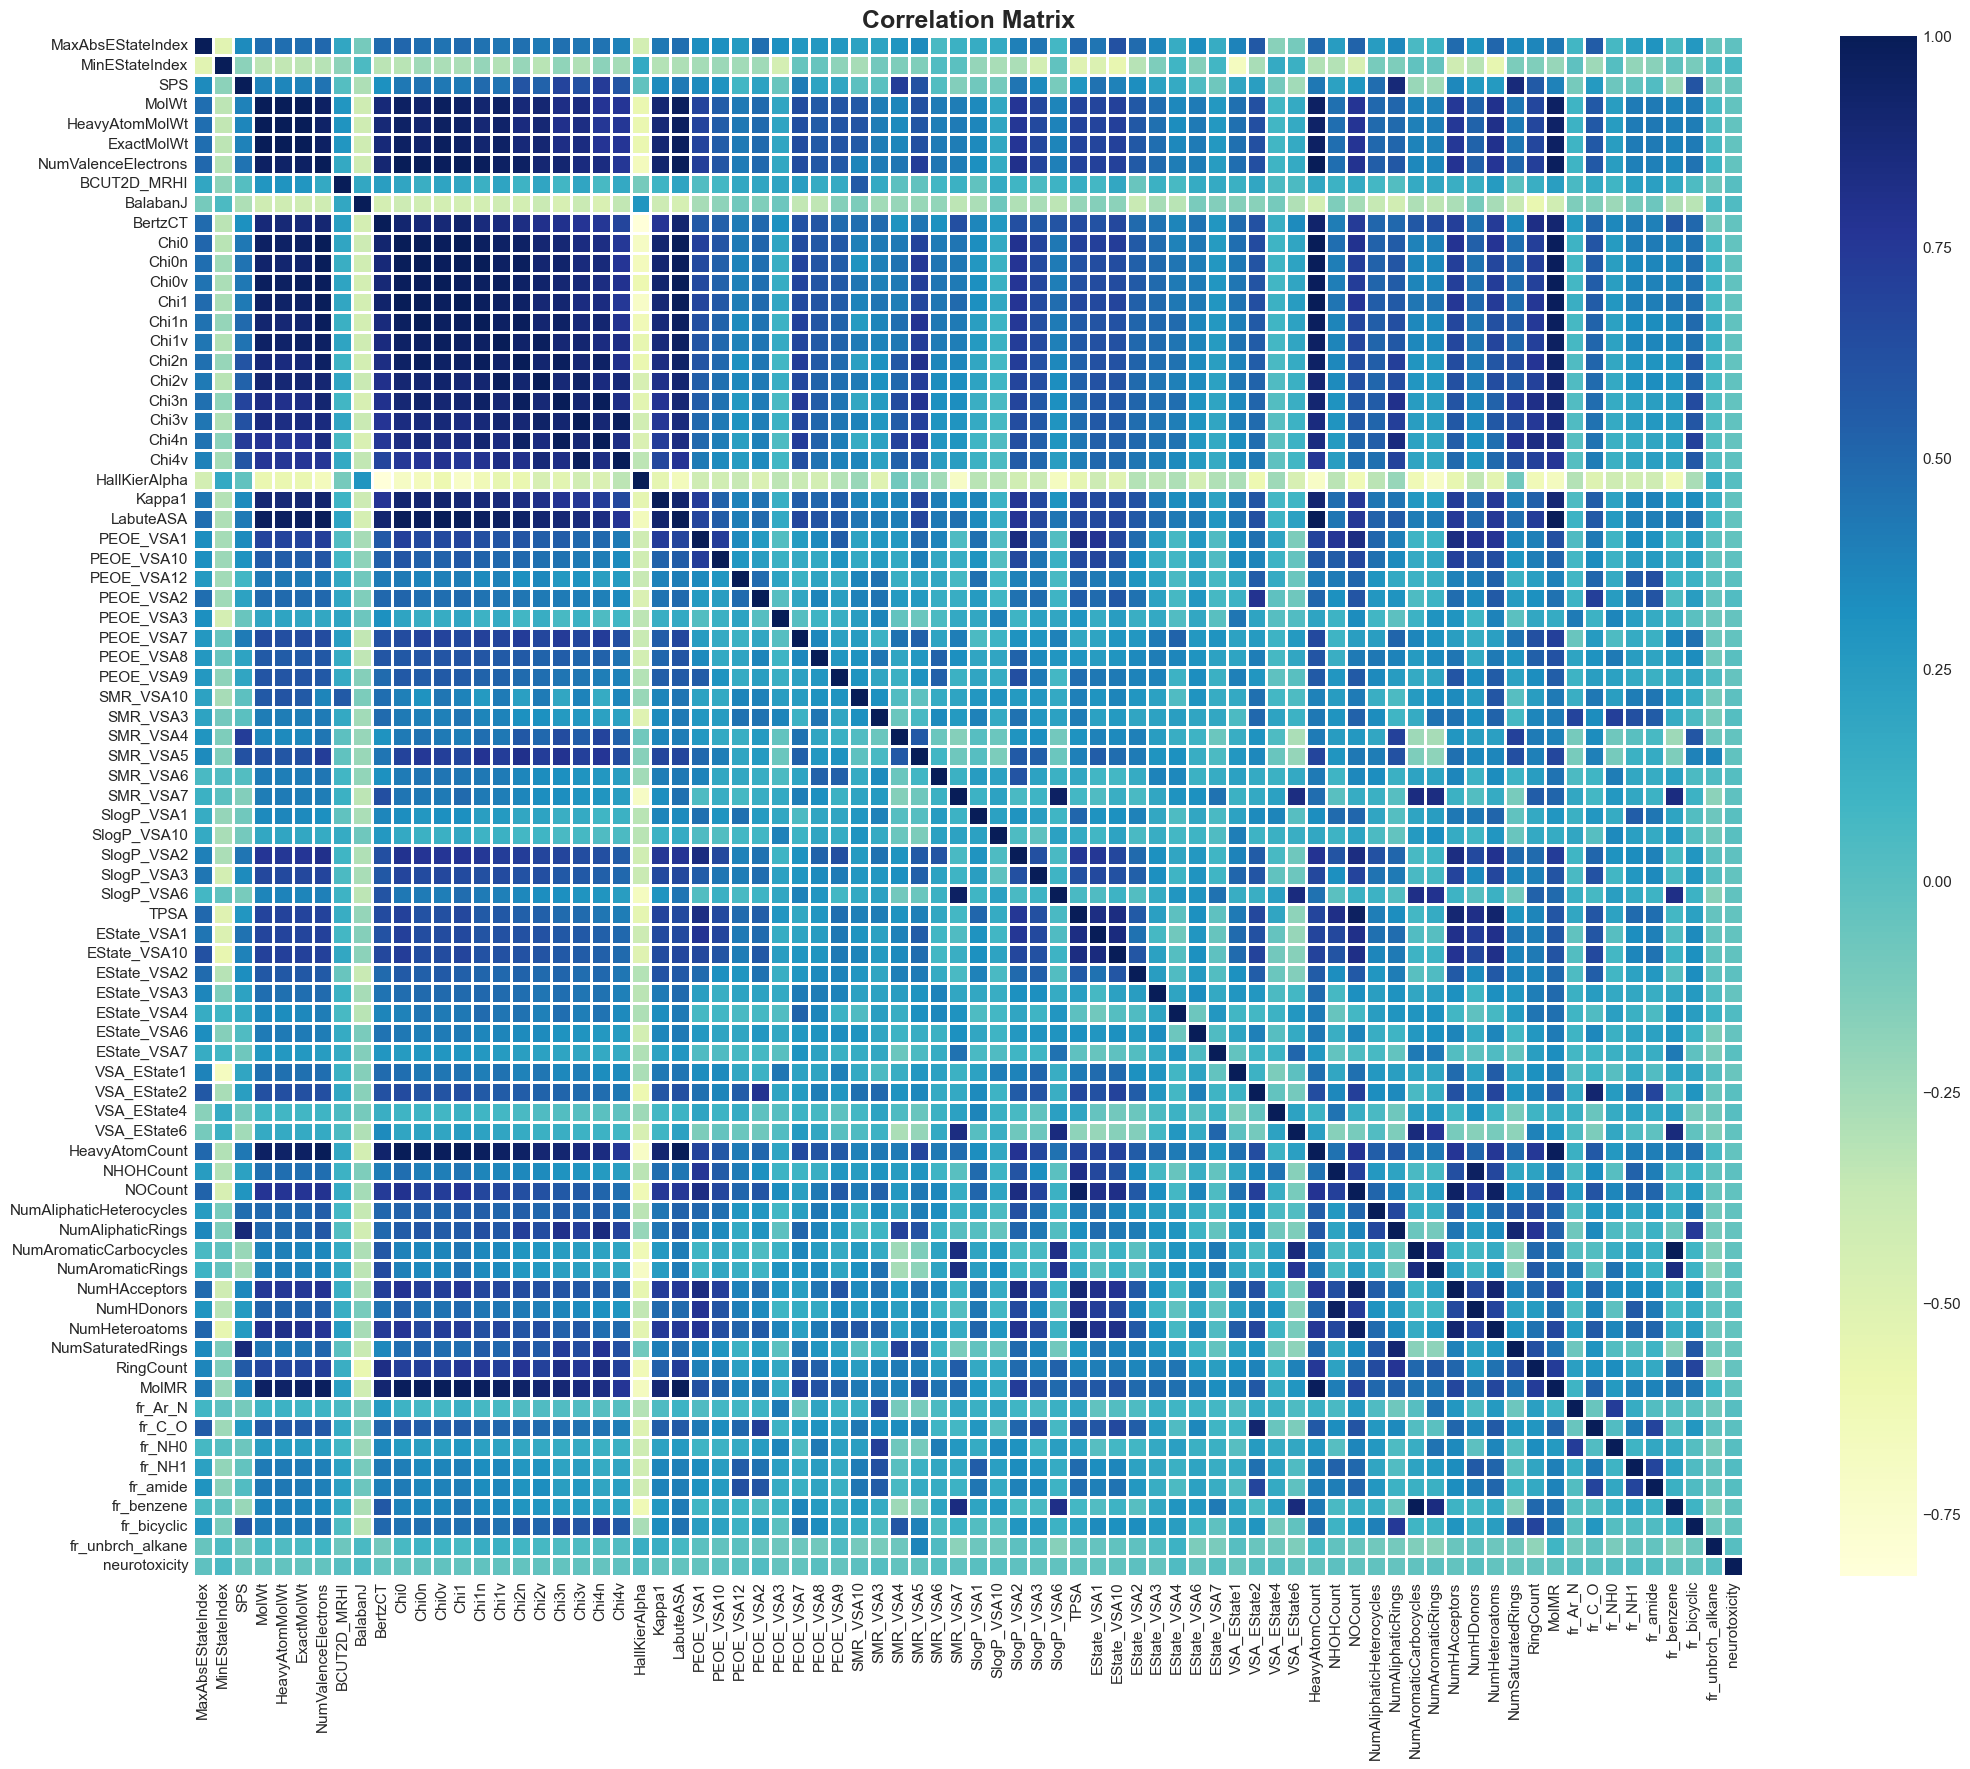

In [28]:
# Making our correlation matrix
df_col_merged = pd.concat([X_train, y_train], axis=1)
corr_matrix = df_col_merged.corr()
fig, ax = plt.subplots(figsize=(25, 20))
ax = sns.heatmap(corr_matrix,
                 annot=False, 
                 linewidths=1,
                 cmap="YlGnBu");
plt.title('Correlation Matrix',fontsize=18, fontweight="bold");

## Machine Learning
We have `analyzed` our data and preformed `feature selection`, now it's time to try and predict our `target variable` using **machine learning**.

### Comparing Different Models

In [29]:
# Put models in a dictionary
models = {"Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Extra-Trees": ExtraTreesClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB()}

# Put evaluation metrics in a dictionary
metrics = {'accuracy': accuracy_score, 'precision': precision_score, 'recall': recall_score, 'f1': f1_score}

In [30]:
# Iterate over each classifier
for name, model in models.items():
            # Setup random seed
            np.random.seed(50)
    
            # Evaluate the best model
            model.fit(X_train, y_train)
            y_preds = model.predict(X_test)

            # Calculate evaluation metrics
            model_scores = {}
            for metric, func in metrics.items():
                model_scores[metric] = func(y_test, y_preds)

            # Print evaluation metrics
            print(f"\nClassifier: {name}")
            for metric, value in model_scores.items():
                if metric in ['accuracy']:
                    print(f"{metric.capitalize()}: {value * 100:.2f}%")
                else:
                    print(f"{metric.capitalize()}: {value:.2f}")


Classifier: Logistic Regression
Accuracy: 73.52%
Precision: 0.76
Recall: 0.83
F1: 0.79

Classifier: Random Forest
Accuracy: 74.58%
Precision: 0.76
Recall: 0.84
F1: 0.80

Classifier: K-Nearest Neighbors
Accuracy: 72.25%
Precision: 0.74
Recall: 0.85
F1: 0.79

Classifier: Extra-Trees
Accuracy: 75.00%
Precision: 0.76
Recall: 0.86
F1: 0.81

Classifier: Decision Tree
Accuracy: 65.04%
Precision: 0.72
Recall: 0.69
F1: 0.70

Classifier: Naive Bayes
Accuracy: 67.16%
Precision: 0.80
Recall: 0.61
F1: 0.69


### Hyperparameter tuning with RandomizedSearchCV
In **Machine Learning**, multiple `hyperparameters` are used to `maximize` the input model’s performance and `generalization ability`. These parameters are not learned from the `training data` but are selected before training the `model`. These parameters can include the number of `epochs`, the number of `hidden layers` in the **neural network**, the number of `trees`, `tree depth` in **random forests**, etc. What **RandomizedSearchCV** does is search for the best `hyperparameter combination` within the predefined distributions that gives the best score as an output.

In [31]:
## Create a function to evaluate the models
def evaluate_preds(y_true, y_preds):
    
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2),
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

In [32]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {"C": np.logspace(-5, 5, 35),
                "solver": ["liblinear"]}

# Setup random seed
np.random.seed(50)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=24,
                                verbose=True)

# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [33]:
y_preds = rs_log_reg.predict(X_test)
evaluate_preds(y_test,y_preds);

Accuracy: 74.58%
Precision: 0.76
Recall: 0.85
F1 score: 0.80


In [34]:
# Create a hyperparameter grid for RandomForestClassifier
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

# Setup random seed
np.random.seed(50)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True,
                           n_jobs=-1)

# Fit random hyperparameter search model
rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [35]:
y_preds = rs_rf.predict(X_test)
evaluate_preds(y_test,y_preds);

Accuracy: 76.06%
Precision: 0.76
Recall: 0.87
F1 score: 0.82


In [36]:
# Create a hyperparameter grid for ExtraTreesClassifier
etc_grid = {'n_estimators': [100,200,300,400,500],
        'bootstrap':[True, False],
        'max_features': ['sqrt','log2',None],
        'max_depth':[2,4,6,8,None]}

# Setup random seed
np.random.seed(50)

# Setup random hyperparameter search for ExtraTreesClassifier
rs_etc = RandomizedSearchCV(ExtraTreesClassifier(),
                           param_distributions=etc_grid,
                           cv=5,
                           n_iter=26,
                           verbose=True,
                           n_jobs=-1)

# Fit random hyperparameter search model
rs_etc.fit(X_train, y_train);

Fitting 5 folds for each of 26 candidates, totalling 130 fits


In [37]:
y_preds = rs_etc.predict(X_test)
evaluate_preds(y_test,y_preds);

Accuracy: 77.75%
Precision: 0.79
Recall: 0.87
F1 score: 0.83


## Analyzing our model
It appears that the **ExtraTreesClassifier** outperforms the **RandomForestClassifier**. Therefore, we will choose the **ExtraTreesClassifier** and proceed by analyzing the `Confusion Matrix` and `ROC Curve`.

In [38]:
# Setup random seed
np.random.seed(50)

etc = ExtraTreesClassifier()
etc_optimized = etc.set_params(**rs_etc.best_params_).fit(X_train, y_train)

y_preds = etc_optimized.predict(X_test)
evaluate_preds(y_test,y_preds);

Accuracy: 77.12%
Precision: 0.78
Recall: 0.87
F1 score: 0.82


### 10-Fold Cross Validation Metrics
**K-Fold Cross Validation** is a technique used in **machine learning** to assess the `performance` of a **predictive model**. It involves splitting the dataset into `k subsets`, or `folds`, and then training the model `k times`, each time using a different `fold` as the `validation set` and the remaining `folds` as the `training set`. This helps to ensure that the `model's performance` is not overly dependent on a particular subset of the data. The results from each iteration are then averaged to provide a more `reliable` estimate of the `model's performance`.

In [39]:
cv_results = cross_validate(etc_optimized, X_train, y_train, cv = 10, scoring = ["accuracy", "precision", "recall", "f1"])

for metric, values in cv_results.items():
                if metric in ["test_accuracy"]:
                    print(f"Accuracy: {values.mean() * 100:.2f}%")
                elif metric in ["test_f1"]:
                    print(f"F1 score: {values.mean():.2f}")
                elif metric in ["test_precision"]:
                    print(f"Precision: {values.mean():.2f}")
                elif metric in ["test_recall"]:
                    print(f"Recall: {values.mean():.2f}")

Accuracy: 76.85%
Precision: 0.77
Recall: 0.88
F1 score: 0.82


### Confusion Matrix
A **confusion matrix** is a table that shows the `performance` of a **classification model** by comparing the `predicted` and actual `class labels`, showing the number of `true positives`, `true negatives`, `false positives`, and `false negatives`.  It helps to evaluate how well the **model** is making `correct predictions` and where it may be making errors.

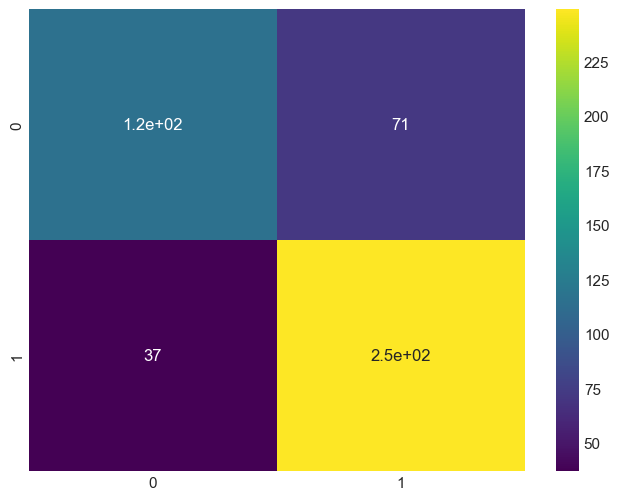

In [40]:
# Making a Confusion Matrix
y_preds = etc_optimized.predict(X_test)

ConfusionMatrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(ConfusionMatrix, cmap="viridis", annot=True);

### ROC curve
An **ROC (Receiver Operating Characteristic) curve** is a graphical representation of the `performance` of a binary classification model. It plots the **true positive rate (sensitivity)** against the **false positive rate (1-specificity)** at various `threshold settings`. The curve helps to visualize the trade-off between `sensitivity` and `specificity` for different threshold values, allowing for the evaluation of the model's performance across a range of `classification thresholds`. A model with a higher area under the `ROC curve` is considered to have better `predictive performance`.

In [41]:
# Create a function for plotting ROC curves
def plot_roc_curve(fpr, tpr):
    # Plot roc curve
    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_probs_positive), color='#0012ff')
    plt.plot([0, 1], [0, 1], color="red", linestyle="--")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

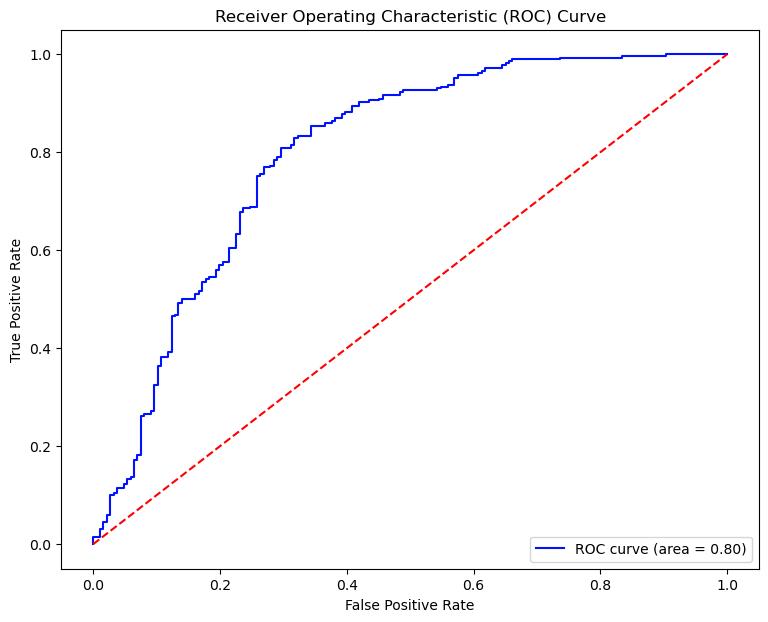

In [42]:
#Choose a style for the plot
plt.style.use("default")

# Make predictions with probabilities
y_probs = etc_optimized.predict_proba(X_test)

# Caculate fpr, tpr and thresholds
y_probs_positive = y_probs[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)
    
plot_roc_curve(fpr, tpr)

### Feature Importance
**Feature importance** in `machine learning` refers to identifying which `input features` have the most impact on predicting the `target variable`. It helps in understanding the key factors influencing the model's predictions.

In [43]:
# Function for plotting feature importance
def plot_features(columns, importances, n=25):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.barh(df["features"][:n], df["feature_importances"][:25], color="royalblue", edgecolor='black')
    ax.set_title('Feature importance', fontsize=14, fontweight="bold")
    ax.invert_yaxis()

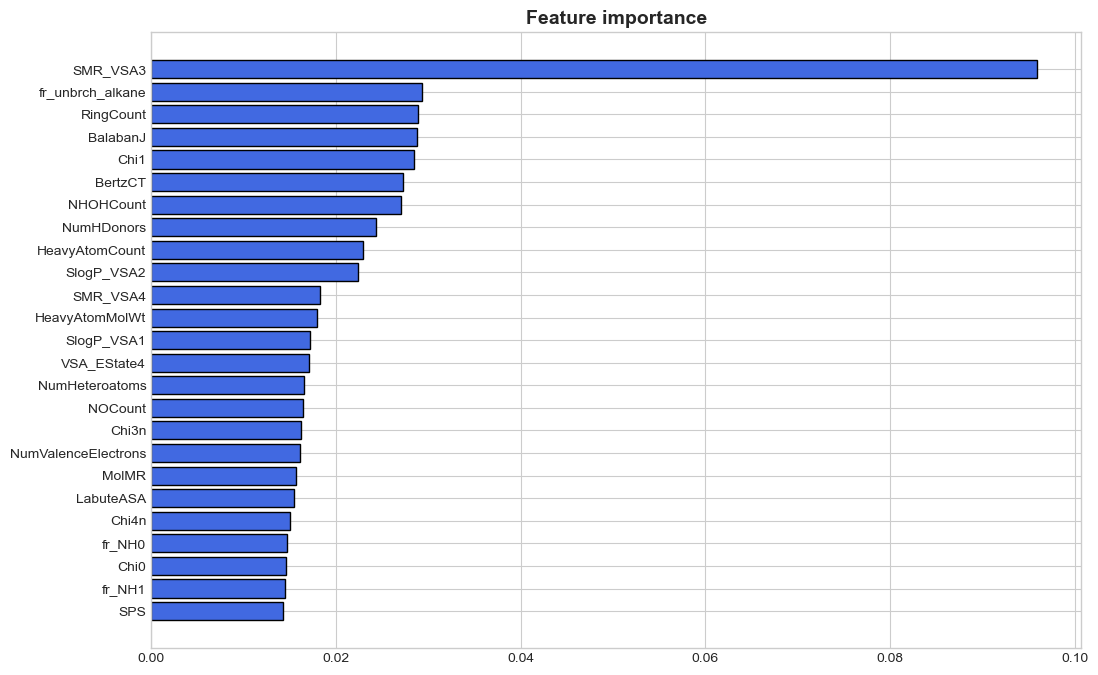

In [44]:
plt.style.use("seaborn-v0_8-whitegrid")
plot_features(X_train.columns, etc.feature_importances_)

## Applicability domain
Given that the `training set` of the **QSAR models** cannot cover the entire `chemical space`, the predictive power and explanatory power of any model for unknown compounds is limited. As a result, an `applicability domain` needs to be defined. Thus, to be deemed **reliable**, a prediction for unknown compound must fall within the `applicability domain`.

In [45]:
cp = Plotter.from_smiles(df["SMILES"], df["neurotoxicity"], target_type="C")
domain = cp.umap()

sim_type indicates the similarity type by which the plots are constructed.
The supported similarity types are structural and tailored.
Because a target list has been provided 'tailored' as been selected as sym_type.
For the following SMILES not all descriptors can be computed:
[N+](=O)([O-])[O-].[N+](=O)([O-])[O-].[Ba+2]
Cl[Sb](Cl)Cl
OB(O)O
[Ca++]
[O-][Se](=O)[O-].[Na+].[Na+]
[N+](=O)([O-])[O-].[Tl+]
Cl[Cd]Cl
[Zr++]
CC(CN1CCN(CCN(CCN(CC1)CC(=O)[O-])CC(=O)[O-])CC(=O)[O-])O.[Gd+3]
C(C1C(C(C(C(O1)[S-])O)O)O)O.[Au+]
CNC(=O)CN(CCN(CCN(CC(=O)NC)CC(=O)[O-])CC(=O)[O-])CC(=O)[O-].O.[Gd+3]
[Br-]
O=[Cd]
[K+]
O=[Mo](=O)=O
O1[As]2O[As]3O[As]1O[As](O2)O3
[O-][Si]1([O-])O[Si]2(O1)O[Si]([O-])([O-])O2
[N+](=O)([O-])[O-].[N+](=O)([O-])[O-].O.O.O.O.O.O.[Mg+2]
[Au+3]
[Ti+4]
[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[N-]=O.O.O.[Na+].[Na+].[Fe+4]
O=[Si]=O
Cl[Pt++]Cl
[N-]=[N+]=[N-]
CCP(CC)CC.CC(=O)OCC1C(C(C(C(O1)[S-])OC(=O)C)OC(=O)C)OC(=O)C.[Au+]
C(C(C(=O)[O-])[S-])C(=O)[O-].O.[Na+].[Na+].[Au+]
NS(O)(=O)=O
[C-]#N.[

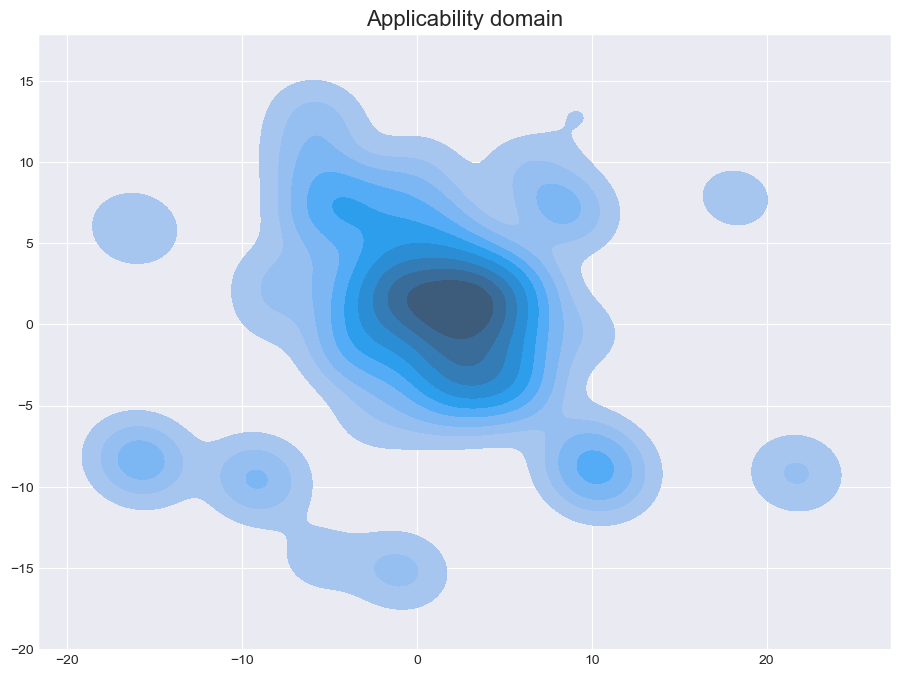

In [46]:
#Choose a style for the plot
sns.set_style("darkgrid")

# Visualising the Applicability domain
plt.figure(figsize=(11,8))
sns.kdeplot(x = 'UMAP-1', y = 'UMAP-2', data=domain, fill=True)
plt.title('Applicability domain', fontsize=16)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12);

## Conclusion
We used the **RDKit Python package** to calculate `molecular descriptors` of over **2,000** chemicals and developed `clasification models` to predict potential **neurotoxic compounds**. Using feature reduction, we selected **77** appropriate descriptors for predicting **neurotoxicity**. Furthermore, we were able to define an **applicability domain** for the model and identify the `descriptors` that had the greatest `impact` on the models' performance.